# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [399]:
# import libraries
# import libraries
#%matplotlib inline
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count,countDistinct,date_trunc, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
import pyspark.sql.types as st
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
sns.set_style('whitegrid')


In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Initial Exploration") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [34]:
df = spark.read.json('mini_sparkify_event_data.json')
df.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [9]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [15]:
df.describe("artist").show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+



In [16]:
df.describe("userId").show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



In [116]:
df.describe("page").show()

+-------+-------+
|summary|   page|
+-------+-------+
|  count| 286500|
|   mean|   null|
| stddev|   null|
|    min|  About|
|    max|Upgrade|
+-------+-------+



In [10]:
#create temp view to run query
df.createOrReplaceTempView("sparkify")

In [11]:
spark.sql("SELECT * FROM sparkify LIMIT 2").show()

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   Canada|   200|1538352180000|"Moz

In [13]:
spark.sql('''
          SELECT COUNT(*) 
          FROM sparkify 
          '''
          ).show()

+--------+
|count(1)|
+--------+
|  286500|
+--------+



In [21]:
#drop duplicates

df.select('*').dropDuplicates().sort("page").show()

+------+----------+---------+------+-------------+--------+------+-----+--------------------+------+-----+-------------+---------+----+------+-------------+--------------------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|            location|method| page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------------------+------+-----+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged Out|     null|  null|           49|    null|  null| paid|                null|   GET|About|         null|     2383|null|   200|1543583700000|                null|      |
|  null|Logged Out|     null|  null|            7|    null|  null| free|                null|   GET|About|         null|     1680|null|   200|1542023877000|                null|      |
|  null| Logged In|    Oscar|     M|           58|Williams|  null| paid|   

In [38]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [41]:
#count nulls for artist field
df.filter(df.sessionId.isNull()).count()

0

In [ ]:
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns])

In [42]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [43]:
#convert to pandas for better visibility
chechnulls = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()

In [45]:
#count nulls per column
chechnulls

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,58392,0,8346,8346,0,8346,58392,0,8346,0,0,8346,0,58392,0,0,8346,0


In [145]:
#convert timestamp to date
def convert_ms(x):
    """Converts given ns to ms"""
    if x is None:
        return None
    
    return x//1000

convert_ms_udf = udf(convert_ms, st.LongType())

df = df.withColumn('timestamp', convert_ms_udf(df.ts).cast('timestamp'))
df = df.withColumn('registration_ts', convert_ms_udf(df.registration).cast('timestamp'))

df.select('ts', 'timestamp', 'registration', 'registration_ts').show(5)

+-------------+-------------------+-------------+-------------------+
|           ts|          timestamp| registration|    registration_ts|
+-------------+-------------------+-------------+-------------------+
|1538352117000|2018-10-01 00:01:57|1538173362000|2018-09-28 22:22:42|
|1538352180000|2018-10-01 00:03:00|1538331630000|2018-09-30 18:20:30|
|1538352394000|2018-10-01 00:06:34|1538173362000|2018-09-28 22:22:42|
|1538352416000|2018-10-01 00:06:56|1538331630000|2018-09-30 18:20:30|
|1538352676000|2018-10-01 00:11:16|1538173362000|2018-09-28 22:22:42|
+-------------+-------------------+-------------+-------------------+
only showing top 5 rows



In [148]:
cleaned_df = df.dropna(how = "all", subset = ["artist", "song","page"])

In [151]:
cleaned_df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+-------------------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|          timestamp|    registration_ts|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+-------------------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|2018-10-01 00:01:

Initially I had removed the nulls if the artists were blank but then we were only left with one Page value. So I had to take out because we will be looking at churn later on. This dataset needs the null values as its significant for further analysis.

In [152]:
#check for duplicate rows  https://stackoverflow.com/questions/48554619/count-number-of-duplicate-rows-in-sparksql
import pyspark.sql.functions  as f

cleaned_df.groupBy(cleaned_df.columns)\
    .count()\
    .where(f.col('count') > 1)\
    .select(f.sum('count'))\
    .show()

+----------+
|sum(count)|
+----------+
|      null|
+----------+



In [134]:
#user interactions
usercounts = cleaned_df.toPandas()
usercounts2 = usercounts.groupby('userId').count()
usercounts2 = usercounts2.reset_index()


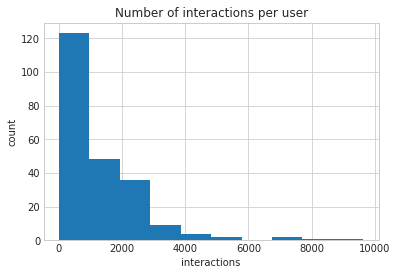

In [135]:
plt.figure()
plt.hist(usercounts2.sessionId.values)
plt.title('Number of interactions per user')
plt.xlabel('interactions')
plt.ylabel('count')
plt.show()

In [136]:
most_listened_artists = cleaned_df.groupby('artist').count().sort('count', ascending=False).toPandas().set_index('artist')
most_listened_artists.head(10)

,count
artist,
NaN,58392
Kings Of Leon,1841
Coldplay,1813
Florence + The Machine,1236
Dwight Yoakam,1135
BjÃÂ¶rk,1133
The Black Keys,1125
Muse,1090
Justin Bieber,1044


Kings of Leon is the highest listened to artist! 

In [137]:
most_listened_songs = cleaned_df.groupby('song').count().sort('count', ascending=False).toPandas().set_index('song')
most_listened_songs.head(10)

,count
song,
NaN,58392
You're The One,1153
Undo,1026
Revelry,854
Sehr kosmisch,728
Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile),641
Dog Days Are Over (Radio Edit),574
Secrets,466
Use Somebody,459


You're the one is the most listened to song

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [167]:
cleaned_df.where(cleaned_df.page=='Cancellation Confirmation').select(['page', 'timestamp', 'userId', 'sessionId', 'level']).show(10)

+--------------------+-------------------+------+---------+-----+
|                page|          timestamp|userId|sessionId|level|
+--------------------+-------------------+------+---------+-----+
|Cancellation Conf...|2018-10-07 20:26:30|    18|      514| paid|
|Cancellation Conf...|2018-10-08 21:10:46|    32|      540| paid|
|Cancellation Conf...|2018-10-12 04:35:18|   125|      174| free|
|Cancellation Conf...|2018-10-12 20:17:21|   105|      508| paid|
|Cancellation Conf...|2018-10-13 21:19:44|    17|      797| paid|
|Cancellation Conf...|2018-10-15 07:34:14|   143|      843| free|
|Cancellation Conf...|2018-10-16 22:30:37|   101|      842| paid|
|Cancellation Conf...|2018-10-17 00:29:21|   129|      802| paid|
|Cancellation Conf...|2018-10-17 07:02:29|   121|      881| paid|
|Cancellation Conf...|2018-10-17 07:39:32|    51|      934| paid|
+--------------------+-------------------+------+---------+-----+
only showing top 10 rows



In [168]:
cleaned_df.where((cleaned_df.userId==125) &
         (cleaned_df.timestamp>'2018-10-12 04:00:18')).sort('ts').select('timestamp', 'page','sessionId', 'level').show()

+-------------------+--------------------+---------+-----+
|          timestamp|                page|sessionId|level|
+-------------------+--------------------+---------+-----+
|2018-10-12 04:05:44|            NextSong|      174| free|
|2018-10-12 04:11:21|            NextSong|      174| free|
|2018-10-12 04:15:11|            NextSong|      174| free|
|2018-10-12 04:18:34|            NextSong|      174| free|
|2018-10-12 04:22:04|            NextSong|      174| free|
|2018-10-12 04:28:35|            NextSong|      174| free|
|2018-10-12 04:32:08|            NextSong|      174| free|
|2018-10-12 04:35:06|            NextSong|      174| free|
|2018-10-12 04:35:17|         Roll Advert|      174| free|
|2018-10-12 04:35:18|              Cancel|      174| free|
|2018-10-12 04:35:18|Cancellation Conf...|      174| free|
+-------------------+--------------------+---------+-----+



The last session was Cancellation confirmation. 

In [169]:
#look at a paid member cancelled
cleaned_df.where((cleaned_df.userId==32) &
         (cleaned_df.timestamp>'2018-10-08 21:00:46')).sort('ts').select('timestamp', 'page','sessionId', 'level').show()

+-------------------+--------------------+---------+-----+
|          timestamp|                page|sessionId|level|
+-------------------+--------------------+---------+-----+
|2018-10-08 21:03:28|            NextSong|      540| paid|
|2018-10-08 21:05:41|            NextSong|      540| paid|
|2018-10-08 21:09:38|            NextSong|      540| paid|
|2018-10-08 21:10:30|           Downgrade|      540| paid|
|2018-10-08 21:10:31|              Cancel|      540| paid|
|2018-10-08 21:10:46|Cancellation Conf...|      540| paid|
+-------------------+--------------------+---------+-----+



The last session was Cancellation confirmation. 

In [257]:
cleaned_df.registerTempTable('check')
spark.sql(
    'SELECT userId, \
    max(timestamp) as maxTime, \
    max(case when  page="Downgrade" then timestamp end) as DowngradeTime,\
    max(case when  page="Cancellation Confirmation" then timestamp end) as cancelTime,\
    sum(case when page="Downgrade" then 1 else 0 end) as c, \
    count(DISTINCT  level) AS n \
    FROM check \
    group by userId \
    having c=1 and n>1').show()

+------+-------------------+-------------------+-------------------+---+---+
|userId|            maxTime|      DowngradeTime|         cancelTime|  c|  n|
+------+-------------------+-------------------+-------------------+---+---+
|    87|2018-10-20 15:49:16|2018-10-20 15:48:57|2018-10-20 15:49:16|  1|  2|
|    73|2018-10-24 17:33:07|2018-10-24 17:32:18|2018-10-24 17:33:07|  1|  2|
|300004|2018-11-14 22:41:25|2018-11-14 19:49:25|               null|  1|  2|
|    44|2018-10-31 11:19:34|2018-10-30 18:06:15|               null|  1|  2|
+------+-------------------+-------------------+-------------------+---+---+



We want to look at the users that have downgraded but not yet cancelled and verify in the range of Downgrade Time that they switched from paid to free

In [258]:
cleaned_df.where((cleaned_df.userId==300004) & 
         (df.timestamp>'2018-11-14 19:45:25') & 
         (df.timestamp<'2018-11-14 19:55:25')).sort('ts').select('timestamp', 'page','sessionId', 'level').show()

+-------------------+----------------+---------+-----+
|          timestamp|            page|sessionId|level|
+-------------------+----------------+---------+-----+
|2018-11-14 19:48:38|        NextSong|      267| paid|
|2018-11-14 19:49:25|       Downgrade|      267| paid|
|2018-11-14 19:49:26|Submit Downgrade|      267| paid|
|2018-11-14 19:49:34|            Home|      267| free|
|2018-11-14 19:52:03|        NextSong|      267| free|
+-------------------+----------------+---------+-----+



Therefore any user with Submit Downgrade or Cancellation Confirmation has Churned. However this project only asks to look at Cancellation Confirmation as primary objective

In [259]:
#filter for cancellation confirmation page and get all the users
churned = cleaned_df.where(cleaned_df.page=='Cancellation Confirmation').select('userId').toPandas().userId.tolist()
#put those users as values in churn to create a column Churn which would be a flag
cleaned_df = cleaned_df.withColumn('churn', cleaned_df.userId.isin(churned))

In [287]:
churn_counts = cleaned_df.groupby('churn').agg(countDistinct('userId'), countDistinct('sessionId')).toPandas()
churn_counts.columns = ['churn', 'user_count', 'session_count']
churn_counts

,churn,user_count,session_count
0,True,52,468
1,False,174,2283


In [263]:
chart_df = cleaned_df.toPandas()

In [268]:
chart_df.dtypes

artist                     object
auth                       object
firstName                  object
gender                     object
itemInSession               int64
lastName                   object
length                    float64
level                      object
location                   object
method                     object
page                       object
registration              float64
sessionId                   int64
song                       object
status                      int64
ts                          int64
userAgent                  object
userId                     object
timestamp          datetime64[ns]
registration_ts    datetime64[ns]
churn                        bool
dtype: object

In [271]:
import pandas as pd
chart_df['timestamp'] = pd.to_datetime(chart_df['timestamp'])
chart_df['timestamp'] = pd.to_datetime(chart_df['timestamp'])

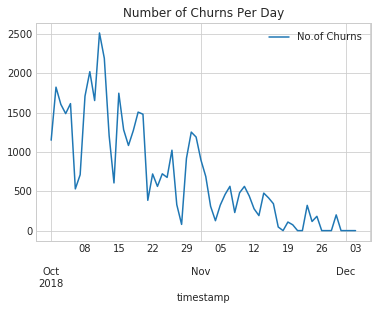

In [276]:
chart_df.groupby(chart_df['timestamp'].dt.to_period("D")).sum()['churn'].plot(label='No.of Churns')
plt.legend()
plt.title('Number of Churns Per Day');

The churns have decreased significantly through time. This is an amazing sign that the business is doing well in retaining customers!

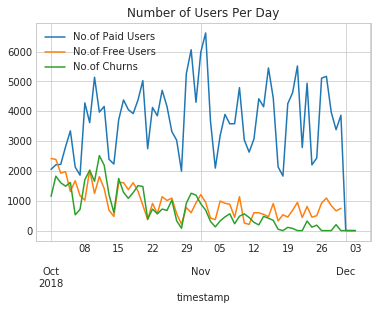

In [281]:
chart_level_paid = chart_df[chart_df['level']=='paid']
chart_level_free = chart_df[chart_df['level']=='free']
chart_level_paid.groupby(chart_level_paid['timestamp'].dt.to_period("D")).count()['userId'].plot(label='No.of Paid Users')
chart_level_free.groupby(chart_level_free['timestamp'].dt.to_period("D")).count()['userId'].plot(label='No.of Free Users')
chart_df.groupby(chart_df['timestamp'].dt.to_period("D")).sum()['churn'].plot(label='No.of Churns')


plt.legend()
plt.title('Number of Users Per Day');

This chart shows the free users, paid users and churned users. We can see that after Nov 12 - the churn reduce and the retention of users is stable.

In [295]:
chart_df2 = chart_df.copy()
chart_df3 = chart_df2.groupby(['page','churn']).agg({'sessionId':'nunique'})
chart_df3= chart_df3.reset_index()


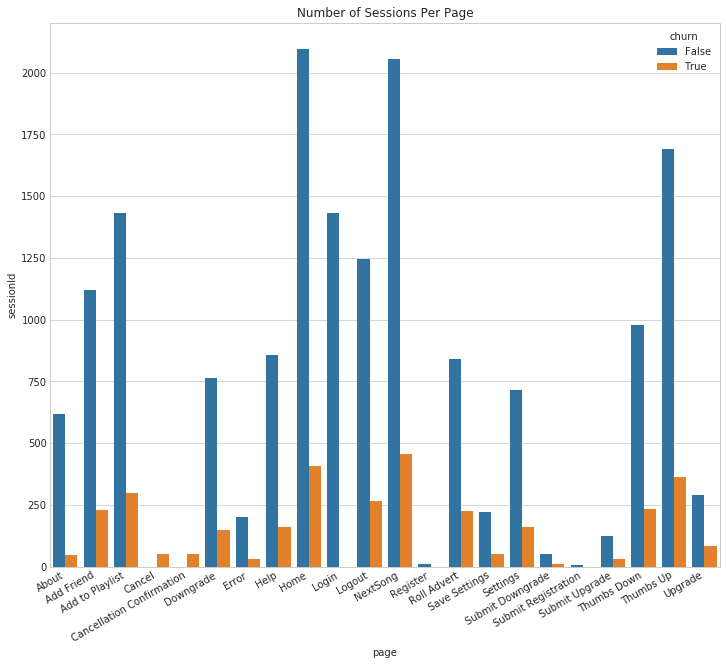

In [312]:
plt.figure(figsize=(12,10))
sns.barplot(x='page',
            y='sessionId',
            hue='churn',
            data=chart_df3)
plt.xticks(rotation=30, ha="right")
plt.title('Number of Sessions Per Page');

Most of the churns have much lower sessions compared to the latter. It also looks like these churns occur in NextSong page and Home page. However, theres also churns occuring at Thumbs up which I found weird. I think although the churns occured at these pages, the cause was for another reason. For example, during nextSong could be when the roll advert occurs so some people churn during the ad but others churn after the ad on on the nextSong page. 

In [307]:
chart_df4 = chart_df.copy()
chart_df4 = chart_df4[chart_df4['page']=='Roll Advert']
chart_df4['Week_Number'] = chart_df4['timestamp'].dt.week
chart_df5 = chart_df4.groupby(['Week_Number','churn']).agg({'sessionId':'nunique'})
chart_df5= chart_df5.reset_index()


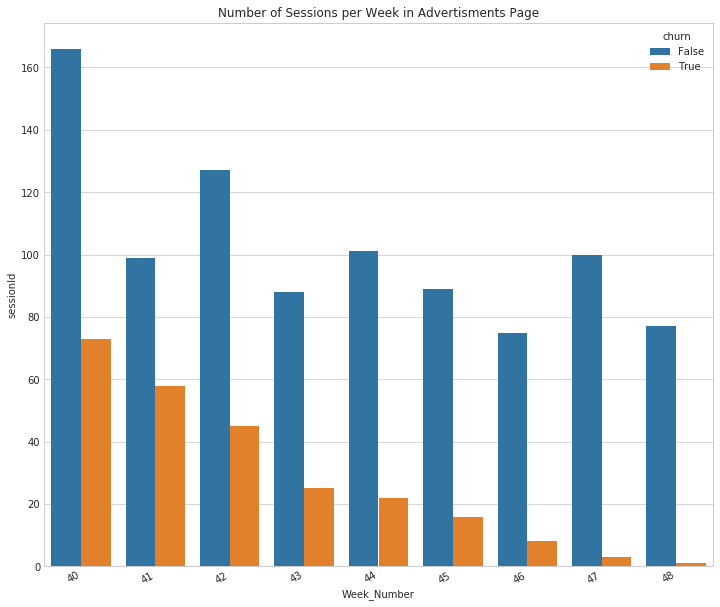

In [311]:
plt.figure(figsize=(12,10))
sns.barplot(x='Week_Number',
            y='sessionId',
            hue='churn',
            data=chart_df5)
plt.xticks(rotation=30, ha="right")
plt.title('Number of Sessions per Week in Advertisments Page');

The churn sessions are low in advertisements per week overtime

In [315]:
chart_df4 = chart_df.copy()
chart_df4 = chart_df4[chart_df4['page']=='NextSong']
chart_df4['Week_Number'] = chart_df4['timestamp'].dt.week
chart_df5 = chart_df4.groupby(['Week_Number','churn']).agg({'sessionId':'nunique'})
chart_df5= chart_df5.reset_index()


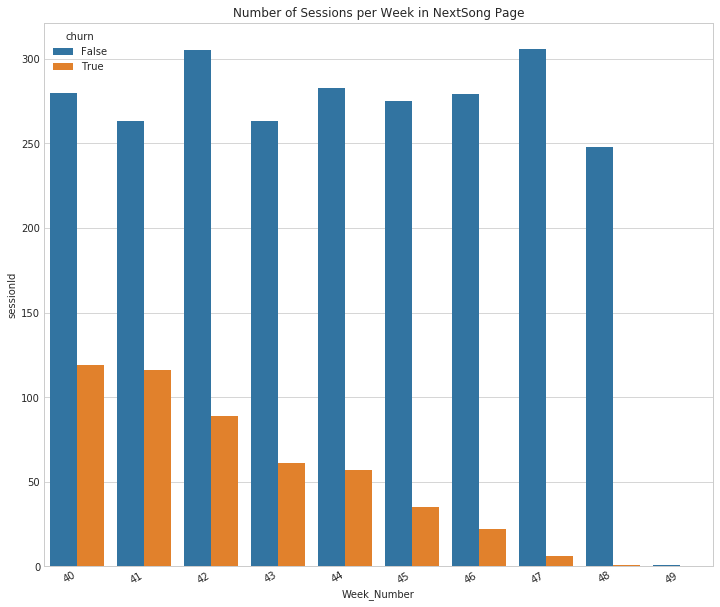

In [316]:
plt.figure(figsize=(12,10))
sns.barplot(x='Week_Number',
            y='sessionId',
            hue='churn',
            data=chart_df5)
plt.xticks(rotation=30, ha="right")
plt.title('Number of Sessions per Week in NextSong Page');

This also shows the same trend as the chart before when we looked at advertisements. There are almost no chars in the second last week. 

## CONCLUSION

Overall, we know the the churns are going down based on the first graphs. Also the user who churn are not using the app as much compared to users that are there. People are really liking the app and we can see this in the week by week decrease in churn sessions. 

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [318]:

def convert_ms(x):
    """Converts given ns to ms"""
    if x is None:
        return None
    
    return x//1000

convert_ms_udf = udf(convert_ms, st.LongType())

In [321]:
def clean_df(df):
    """
    Takes in a raw events dataframe, makes a few extra columns and cleans it.
    """
    
    # Remove bad userIds
    cleaned_df = df.filter(df.userId != "")
    cleaned_df.persist()
    
    # Clean time columns
    cleaned_df = cleaned_df.withColumn('timestamp', convert_ms_udf(cleaned_df.ts).cast('timestamp'))
    cleaned_df = cleaned_df.withColumn('registration_ts', convert_ms_udf(cleaned_df.registration).cast('timestamp'))
    
    return df


In [323]:
# after reading in the df just running this cell catches up with the exploration
cleaned_df = clean_df(df)

pages = df.select('page').distinct().sort('page')
pages_list = [r.page for r in pages.collect()]

Feature 1 = Count of SessionIds

In [325]:
sessions = cleaned_df.groupby('userId').agg(countDistinct('sessionId').alias('session_count'))


Feature 2 = Count of Songs per Week

In [332]:
songs = cleaned_df.where(cleaned_df.page=='NextSong') \
                .groupby('userId', date_trunc('week', 'timestamp').cast('date').alias('week')).count() \
                .groupby('userId').pivot('week').sum().fillna(0)

Feature 3 = Gender

In [333]:
genders = cleaned_df.select('userId', when(col('gender')=='F', 0).otherwise(1).alias('genders')).distinct()


In [387]:
def feature_df(df):
    """Takes in a cleaned dataframe and returns a feature dataframe"""
    
    # List of columns to include in the vector
    vector_cols = []
    
    # Session counts
    session_counts = cleaned_df.groupby('userId').agg(countDistinct('sessionId').alias('session_count'))
    vector_cols.append('session_count')
    
    # Page list and events to ignore
    pages_list = [r.page for r in pages.collect()]
    drop_events = ['Cancel']
    
    # Get page counts per userId
    df_feature = cleaned_df.groupby('userId').pivot('page', pages_list).count()
    df_feature = df_feature.withColumnRenamed('Cancellation Confirmation', 'label')
    df_feature = df_feature.drop(*drop_events).fillna(0)
    
    df_feature = df_feature.join(session_counts, on='userId')
 
    # Week song counts
    songs = cleaned_df.where(cleaned_df.page=='NextSong') \
                .groupby('userId', date_trunc('week', 'timestamp').cast('date').alias('week')).count() \
                .groupby('userId').pivot('week').sum().fillna(0)
    
    vector_cols.extend(week_counts.columns[1:])
    #joining the session counts and week counts
    df_feature = df_feature.join(week_counts, on='userId')
    
    # Get genders
    genders = cleaned_df.select('userId', when(col('gender')=='F', 0).otherwise(1).alias('genders')).distinct()
    
    vector_cols.append('genders')
    
    #join our main dataframe with genders to add in those values
    df_feature = df_feature.join(genders, on='userId')
    
    # Assemble the vector
    assembler = VectorAssembler(inputCols=vector_cols, outputCol='features')
    
    return assembler.transform(df_feature)

In [388]:
feature_df_main = feature_df(df)


In [389]:
feature_df_main.printSchema()


root
 |-- userId: string (nullable = true)
 |-- About: long (nullable = true)
 |-- Add Friend: long (nullable = true)
 |-- Add to Playlist: long (nullable = true)
 |-- label: long (nullable = true)
 |-- Downgrade: long (nullable = true)
 |-- Error: long (nullable = true)
 |-- Help: long (nullable = true)
 |-- Home: long (nullable = true)
 |-- Login: long (nullable = true)
 |-- Logout: long (nullable = true)
 |-- NextSong: long (nullable = true)
 |-- Register: long (nullable = true)
 |-- Roll Advert: long (nullable = true)
 |-- Save Settings: long (nullable = true)
 |-- Settings: long (nullable = true)
 |-- Submit Downgrade: long (nullable = true)
 |-- Submit Registration: long (nullable = true)
 |-- Submit Upgrade: long (nullable = true)
 |-- Thumbs Down: long (nullable = true)
 |-- Thumbs Up: long (nullable = true)
 |-- Upgrade: long (nullable = true)
 |-- session_count: long (nullable = false)
 |-- 2018-10-01: long (nullable = true)
 |-- 2018-10-08: long (nullable = true)
 |-- 2018-1

In [382]:
#count how many features we have
feature_df_main.select('features').count()


278154

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [390]:
train, test = feature_df_main.randomSplit([0.8, 0.2], seed=42)


In [403]:
def model_results(res):
    """Given a results vector returns accuracy and f1-score"""
    total = res.count()
    
    tp = res.where((res.label==1) & (res.prediction==1)).count()
    tn = res.where((res.label==0) & (res.prediction==0)).count()
    
    fp = res.where((res.label==1) &  (res.prediction==1)).count()
    fn = res.where((res.label==0) & (res.prediction==0)).count()
        
    accuracy = (1.0*tp + tn) / total
    precision = 1.0*tp / (tp + fp)
    recall = 1.0*tp / (tp + fn)
    f1 = 2.0 * (precision * recall) / (precision + recall)
    
    print('Accuracy: ', round(accuracy, 2))
    print('Precision: ', round(precision, 2))
    print('Recall: ', round(recall, 2))
    print('F1-Score: ', round(f1, 2))

In [404]:
#create alogistic regression ml 
logRe =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)


In [405]:
#fit out logit model
logRe_model = logRe.fit(train)


In [406]:
#we apply trained model on test set
results = logRe_model.transform(test)


In [407]:
model_results(results)

Accuracy:  0.74
Precision:  0.5
Recall:  0.08
F1-Score:  0.14


The logistics regression model did not perform well so we can try other models

In [408]:
#decisionTree Model
dt = DecisionTreeClassifier()
dt_model = dt.fit(train)
results_dt = dt_model.transform(test)
model_results(results_dt)

Accuracy:  0.85
Precision:  0.5
Recall:  0.17
F1-Score:  0.26


The decision tree model performed better than the logistic regression model. 

In [409]:
rf = RandomForestClassifier()
rf_model = rf.fit(train)
results_rf = rf_model.transform(test)
get_metrics(results_rf)

Accuracy:  0.88
Precision:  0.75
Recall:  0.75
F1-Score:  0.75


## CONCLUSION

Overall,  I got to clean and analyze trends in this data to get the features I wanted to try. After trying the features and building the model - at first it did not look good with Logistic Regression. However, it got a bit better with Decition Tree model. Finally, Regression Model did the best with F1 score of 0.75! I was happy to see this result.